In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960

# Imports
<div style="width:100%;height:0;border-bottom: 3px solid #F03A4F;margin-bottom: 1rem;"></div>

In [ ]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 19.4 MB/s eta 0:00:00


In [ ]:
%env WANDB_DISABLED=True

env: WANDB_DISABLED=True


In [ ]:
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import shutil
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparing Dataset
<div style="width:100%;height:0;border-bottom: 3px solid #F27B40;margin-bottom: 1rem;"></div>

In [ ]:
base_dir = Path('/content/drive/MyDrive/Colab Notebooks/Interview Test/kitti')
img_path = base_dir / 'training'
label_path = base_dir / 'label'
with open('/content/drive/MyDrive/Colab Notebooks/Interview Test/kitti/classes.json','r') as f:
    classes = json.load(f)

classes

{'Car': 0,
 'Pedestrian': 1,
 'Van': 2,
 'Cyclist': 3,
 'Truck': 4,
 'Misc': 5,
 'Tram': 6,
 'Person_sitting': 7}

In [ ]:
ims = sorted(list(img_path.glob('*')))
labels = sorted(list(label_path.glob('*')))
pairs = list(zip(ims,labels))
pairs[:2]

[(PosixPath('/content/drive/MyDrive/Colab Notebooks/Interview Test/kitti/training/000000.png'),
  PosixPath('/content/drive/MyDrive/Colab Notebooks/Interview Test/kitti/label/000000.txt')),
 (PosixPath('/content/drive/MyDrive/Colab Notebooks/Interview Test/kitti/training/000001.png'),
  PosixPath('/content/drive/MyDrive/Colab Notebooks/Interview Test/kitti/label/000001.txt'))]

In [ ]:
train, test = train_test_split(pairs,test_size=0.1,shuffle=True)
len(train), len(test)

(900, 100)

In [ ]:
train_path = Path('train').resolve()
train_path.mkdir(exist_ok=True)
valid_path = Path('valid').resolve()
valid_path.mkdir(exist_ok=True)

In [ ]:
for t_img, t_lb in tqdm(train):
    im_path = train_path / t_img.name
    lb_path = train_path / t_lb.name
    shutil.copy(t_img,im_path)
    shutil.copy(t_lb,lb_path)

  0%|          | 0/900 [00:00<?, ?it/s]

In [ ]:
for t_img, t_lb in tqdm(test):
    im_path = valid_path / t_img.name
    lb_path = valid_path / t_lb.name
    shutil.copy(t_img,im_path)
    shutil.copy(t_lb,lb_path)

  0%|          | 0/100 [00:00<?, ?it/s]

# YAML file for the data
<div style="width:100%;height:0;border-bottom: 3px solid #F4CE45;margin-bottom: 1rem;"></div>

In [ ]:
yaml_file = 'names:\n'
yaml_file += '\n'.join(f'- {c}' for c in classes)
yaml_file += f'\nnc: {len(classes)}'
yaml_file += f'\ntrain: {str(train_path)}\nval: {str(valid_path)}'
with open('kitti.yaml','w') as f:
    f.write(yaml_file)

In [ ]:
!cat kitti.yaml

names:
- Car
- Pedestrian
- Van
- Cyclist
- Truck
- Misc
- Tram
- Person_sitting
nc: 8
train: /content/train
val: /content/valid

# Model
<div style="width:100%;height:0;border-bottom: 3px solid #F27B40;margin-bottom: 1rem;"></div>

In [ ]:
model = YOLO('yolov8n.yaml')
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 127MB/s]


# Training
<div style="width:100%;height:0;border-bottom: 3px solid #F5E947;margin-bottom: 1rem;"></div>

In [ ]:
train_results = model.train(
    data='/content/kitti.yaml',
    epochs=50,
    patience=3,
    mixup=0.1,
    project='yolov8n-kitti',
    device=0
)

Ultralytics 8.3.9 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/kitti.yaml, epochs=50, time=None, patience=3, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=yolov8n-kitti, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

100%|██████████| 5.35M/5.35M [00:00<00:00, 91.9MB/s]


AMP: checks passed ✅


train: Scanning /content/train... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:02<00:00, 435.22it/s]


train: New cache created: /content/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/valid... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 284.15it/s]

val: New cache created: /content/valid.cache


Plotting labels to yolov8n-kitti/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to yolov8n-kitti/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.82G      1.648        3.7      1.155         48        640: 100%|██████████| 57/57 [00:31<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        100        543     0.0062      0.292      0.071     0.0414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.5G      1.601      2.116      1.141         29        640: 100%|██████████| 57/57 [00:26<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        100        543      0.929     0.0498      0.154     0.0897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.42G      1.491       1.69      1.131         76        640: 100%|██████████| 57/57 [00:25<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


                   all        100        543       0.49        0.2      0.207      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.59G      1.427      1.569      1.118         33        640: 100%|██████████| 57/57 [00:25<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

                   all        100        543      0.524      0.279      0.276      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.54G      1.393      1.475      1.099         45        640: 100%|██████████| 57/57 [00:28<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


                   all        100        543       0.51       0.25      0.279      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.63G       1.38      1.421      1.105         36        640: 100%|██████████| 57/57 [00:24<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        100        543      0.789       0.24      0.303      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.45G      1.347      1.361      1.086         36        640: 100%|██████████| 57/57 [00:26<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

                   all        100        543      0.591      0.265      0.298      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       2.6G      1.313      1.295      1.077         86        640: 100%|██████████| 57/57 [00:25<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


                   all        100        543      0.421      0.348      0.343      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.59G      1.318      1.301      1.087         30        640: 100%|██████████| 57/57 [00:26<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

                   all        100        543      0.644      0.295      0.344      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.55G      1.281      1.243      1.067         39        640: 100%|██████████| 57/57 [00:24<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]

                   all        100        543      0.435      0.317      0.342       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.72G      1.267      1.189      1.068         35        640: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


                   all        100        543      0.334      0.413      0.353      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.39G      1.273        1.2      1.055         83        640: 100%|██████████| 57/57 [00:24<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

                   all        100        543      0.745      0.273      0.359       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       2.6G      1.251      1.159      1.053         54        640: 100%|██████████| 57/57 [00:26<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        100        543      0.446      0.403      0.421      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.73G      1.254      1.137      1.055         78        640: 100%|██████████| 57/57 [00:27<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        100        543       0.53      0.352      0.378      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.85G      1.231      1.121      1.052         19        640: 100%|██████████| 57/57 [00:27<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]


                   all        100        543      0.371      0.417       0.43      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.74G      1.196      1.071       1.04         37        640: 100%|██████████| 57/57 [00:24<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all        100        543       0.36      0.488      0.423      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.46G      1.208       1.06      1.036         32        640: 100%|██████████| 57/57 [00:27<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]


                   all        100        543      0.415       0.41      0.431      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.79G      1.177      1.037      1.025         23        640: 100%|██████████| 57/57 [00:24<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

                   all        100        543      0.543      0.415      0.446      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.61G      1.186      1.021      1.035         29        640: 100%|██████████| 57/57 [00:27<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


                   all        100        543      0.545      0.474      0.496       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.39G      1.166      1.007      1.024         33        640: 100%|██████████| 57/57 [00:24<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


                   all        100        543       0.68      0.345      0.461      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.54G      1.182      1.001      1.031         40        640: 100%|██████████| 57/57 [00:29<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        100        543      0.621      0.409      0.483      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.63G      1.168      1.002      1.025         85        640: 100%|██████████| 57/57 [00:24<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


                   all        100        543      0.633      0.436        0.5      0.307
EarlyStopping: Training stopped early as no improvement observed in last 3 epochs. Best results observed at epoch 19, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

22 epochs completed in 0.182 hours.
Optimizer stripped from yolov8n-kitti/train/weights/last.pt, 5.6MB
Optimizer stripped from yolov8n-kitti/train/weights/best.pt, 5.6MB

Validating yolov8n-kitti/train/weights/best.pt...
Ultralytics 8.3.9 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 186 layers, 2,685,928 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


                   all        100        543      0.542      0.475      0.495       0.31
                   Car         90        373      0.804      0.845      0.892      0.637
            Pedestrian         24         60      0.527        0.4      0.407      0.227
                   Van         27         41        0.4        0.7      0.546      0.377
               Cyclist         18         24      0.526      0.417      0.455      0.293
                 Truck         11         12      0.677      0.833      0.721      0.518
                  Misc         10         11      0.141     0.0909     0.0645     0.0382
                  Tram          7         13      0.266      0.231      0.273      0.184
        Person_sitting          3          9          1      0.281      0.603      0.208
Speed: 0.2ms preprocess, 4.2ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to yolov8n-kitti/train


# Validation
<div style="width:100%;height:0;border-bottom: 3px solid #E7F549;margin-bottom: 1rem;"></div>

In [ ]:
valid_results = model.val()

Ultralytics 8.3.9 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 186 layers, 2,685,928 parameters, 0 gradients, 6.8 GFLOPs


val: Scanning /content/valid.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


                   all        100        543      0.489      0.464      0.472       0.31
                   Car         90        373      0.804      0.847      0.892      0.639
            Pedestrian         24         60      0.545       0.42      0.415      0.232
                   Van         27         41      0.401      0.701      0.547      0.381
               Cyclist         18         24      0.498      0.417      0.454      0.293
                 Truck         11         12      0.669      0.833      0.721      0.522
                  Misc         10         11       0.14     0.0909     0.0645      0.038
                  Tram          7         13      0.265      0.231      0.273      0.184
        Person_sitting          3          9      0.589       0.17      0.409      0.189
Speed: 0.2ms preprocess, 7.9ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to yolov8n-kitti/train2


# Results
<div style="width:100%;height:0;border-bottom: 3px solid #F25F3E;margin-bottom: 1rem;"></div>

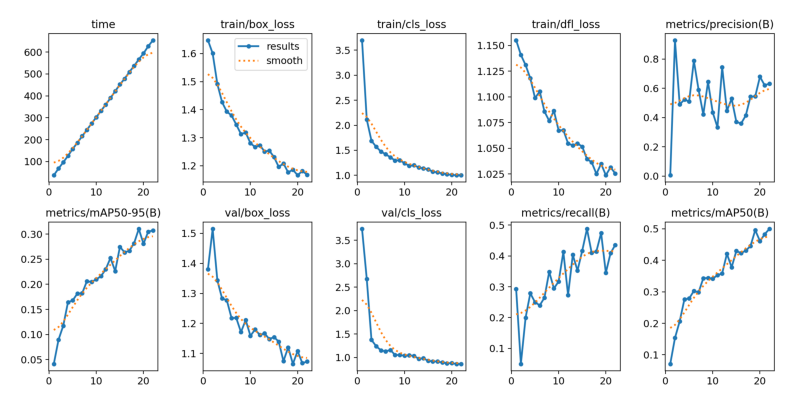

In [ ]:
plt.figure(figsize=(10,20))
plt.imshow(Image.open('yolov8n-kitti/train/results.png'))
plt.axis('off')
plt.show()

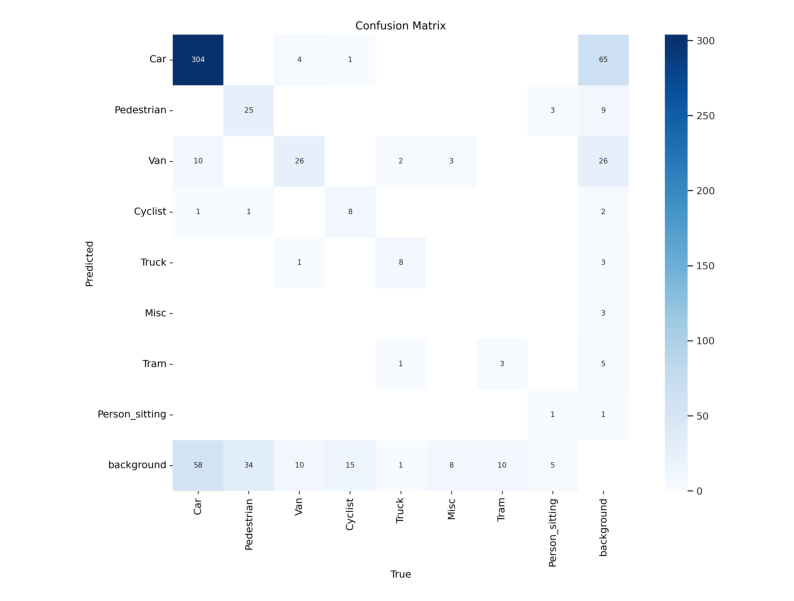

In [ ]:
plt.figure(figsize=(10,20))
plt.imshow(Image.open('yolov8n-kitti/train/confusion_matrix.png'))
plt.axis('off')
plt.show()

# Predictions
<div style="width:100%;height:0;border-bottom: 3px solid #CEF64B;margin-bottom: 1rem;"></div>

In [ ]:
preds = model.predict([test[idx][0] for idx in np.random.randint(0,len(test),(20,))],save=True)


0: 640x640 3 Pedestrians, 4.7ms
1: 640x640 1 Car, 4.7ms
2: 640x640 3 Cars, 4.7ms
3: 640x640 7 Cars, 4 Vans, 1 Truck, 4.7ms
4: 640x640 7 Cars, 4 Vans, 1 Truck, 4.7ms
5: 640x640 5 Cars, 2 Vans, 4.7ms
6: 640x640 4 Cars, 1 Pedestrian, 1 Van, 4.7ms
7: 640x640 2 Cars, 2 Trams, 4.7ms
8: 640x640 1 Pedestrian, 4.7ms
9: 640x640 2 Cars, 1 Cyclist, 4.7ms
10: 640x640 1 Car, 4.7ms
11: 640x640 8 Cars, 2 Vans, 4.7ms
12: 640x640 8 Cars, 2 Vans, 4.7ms
13: 640x640 1 Pedestrian, 4.7ms
14: 640x640 6 Cars, 4.7ms
15: 640x640 1 Car, 1 Van, 4.7ms
16: 640x640 3 Cars, 1 Van, 4.7ms
17: 640x640 2 Cars, 1 Cyclist, 4.7ms
18: 640x640 6 Cars, 3 Vans, 4.7ms
19: 640x640 8 Cars, 2 Vans, 4.7ms
Speed: 4.8ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to yolov8n-kitti/train3


In [ ]:
preds = list(Path('yolov8n-kitti/predict').glob('*'))

In [ ]:
preds

[PosixPath('yolov8n-kitti/predict/000267.png'),
 PosixPath('yolov8n-kitti/predict/000413.png'),
 PosixPath('yolov8n-kitti/predict/000738.png'),
 PosixPath('yolov8n-kitti/predict/000497.png'),
 PosixPath('yolov8n-kitti/predict/000196.png'),
 PosixPath('yolov8n-kitti/predict/000481.png'),
 PosixPath('yolov8n-kitti/predict/000251.png'),
 PosixPath('yolov8n-kitti/predict/000531.png'),
 PosixPath('yolov8n-kitti/predict/000141.png'),
 PosixPath('yolov8n-kitti/predict/000784.png'),
 PosixPath('yolov8n-kitti/predict/000982.png'),
 PosixPath('yolov8n-kitti/predict/000501.png'),
 PosixPath('yolov8n-kitti/predict/000819.png'),
 PosixPath('yolov8n-kitti/predict/000987.png'),
 PosixPath('yolov8n-kitti/predict/000957.png'),
 PosixPath('yolov8n-kitti/predict/000706.png')]

In [ ]:
def plot_images(images):
    num_images = len(images)
    rows = num_images
    cols = 1
    fig, axes = plt.subplots(rows, cols, figsize=(15, 80))
    for ax in axes.flat:
        ax.axis('off')
    for i, img_path in enumerate(images):
        img = Image.open(img_path)
        axes[i].imshow(img)

    plt.tight_layout()
    plt.show()

plot_images(preds)

Output hidden; open in https://colab.research.google.com to view.

In [41]:
shutil.move("/content/yolov8n-kitti", "/content/drive/MyDrive/Colab Notebooks/Interview Test")

'/content/drive/MyDrive/Colab Notebooks/Interview Test/yolov8n-kitti'